# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [4]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [5]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

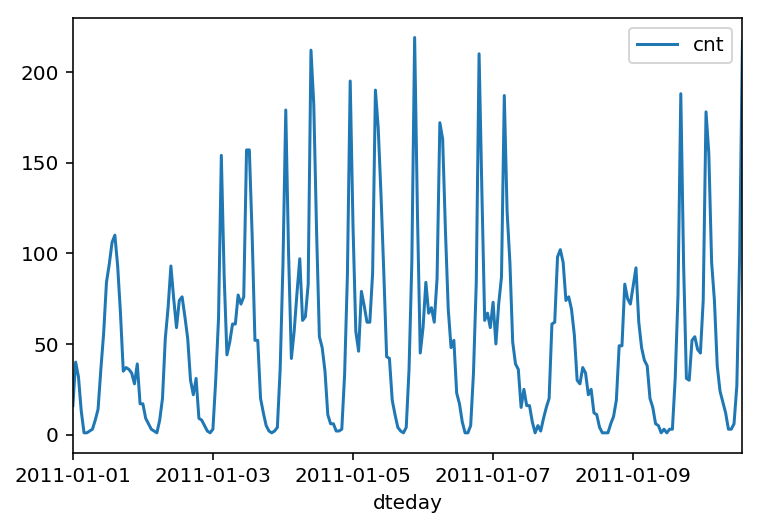

In [6]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [7]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [8]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [9]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [10]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure. You'll implement both the forward pass and backwards pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [11]:
#############
# In the my_answers.py file, fill out the TODO sections as specified
#############

from my_answers import NeuralNetwork

In [12]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [13]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.011s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations.  You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.  You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [14]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

from my_answers import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    print (' ... Iteration:'+str(ii))
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Iteration:0
Progress: 0.0% ... Training loss: 2.963 ... Validation loss: 4.717Iteration:1
Progress: 0.0% ... Training loss: 17.21 ... Validation loss: 13.84Iteration:2
Progress: 0.1% ... Training loss: 90.86 ... Validation loss: 96.45Iteration:3
Progress: 0.1% ... Training loss: 12.04 ... Validation loss: 3.716Iteration:4
Progress: 0.1% ... Training loss: 4.041 ... Validation loss: 1.612Iteration:5
Progress: 0.1% ... Training loss: 3.430 ... Validation loss: 1.508Iteration:6
Progress: 0.2% ... Training loss: 2.904 ... Validation loss: 1.428

C:\Users\Szidi\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Iteration:7
Progress: 0.2% ... Training loss: 2.575 ... Validation loss: 1.384Iteration:8
Progress: 0.2% ... Training loss: 2.286 ... Validation loss: 1.345Iteration:9
Progress: 0.3% ... Training loss: 2.100 ... Validation loss: 1.324Iteration:10
Progress: 0.3% ... Training loss: 1.975 ... Validation loss: 1.312Iteration:11
Progress: 0.3% ... Training loss: 1.841 ... Validation loss: 1.303Iteration:12
Progress: 0.4% ... Training loss: 1.745 ... Validation loss: 1.292Iteration:13
Progress: 0.4% ... Training loss: 1.661 ... Validation loss: 1.290Iteration:14
Progress: 0.4% ... Training loss: 1.608 ... Validation loss: 1.288Iteration:15
Progress: 0.4% ... Training loss: 1.552 ... Validation loss: 1.286Iteration:16
Progress: 0.5% ... Training loss: 1.494 ... Validation loss: 1.282Iteration:17
Progress: 0.5% ... Training loss: 1.460 ... Validation loss: 1.280Iteration:18
Progress: 0.5% ... Training loss: 1.424 ... Validation loss: 1.279Iteration:19
Progress: 0.6% ... Training loss: 1.394 ..

Progress: 3.2% ... Training loss: 0.945 ... Validation loss: 1.339Iteration:111
Progress: 3.3% ... Training loss: 0.943 ... Validation loss: 1.339Iteration:112
Progress: 3.3% ... Training loss: 0.942 ... Validation loss: 1.339Iteration:113
Progress: 3.3% ... Training loss: 0.941 ... Validation loss: 1.339Iteration:114
Progress: 3.4% ... Training loss: 0.940 ... Validation loss: 1.337Iteration:115
Progress: 3.4% ... Training loss: 0.938 ... Validation loss: 1.338Iteration:116
Progress: 3.4% ... Training loss: 0.937 ... Validation loss: 1.337Iteration:117
Progress: 3.4% ... Training loss: 0.935 ... Validation loss: 1.337Iteration:118
Progress: 3.5% ... Training loss: 0.933 ... Validation loss: 1.337Iteration:119
Progress: 3.5% ... Training loss: 0.931 ... Validation loss: 1.337Iteration:120
Progress: 3.5% ... Training loss: 0.930 ... Validation loss: 1.337Iteration:121
Progress: 3.6% ... Training loss: 0.928 ... Validation loss: 1.337Iteration:122
Progress: 3.6% ... Training loss: 0.926 

Progress: 6.2% ... Training loss: 0.750 ... Validation loss: 1.286Iteration:213
Progress: 6.3% ... Training loss: 0.748 ... Validation loss: 1.283Iteration:214
Progress: 6.3% ... Training loss: 0.747 ... Validation loss: 1.282Iteration:215
Progress: 6.3% ... Training loss: 0.746 ... Validation loss: 1.281Iteration:216
Progress: 6.4% ... Training loss: 0.745 ... Validation loss: 1.279Iteration:217
Progress: 6.4% ... Training loss: 0.744 ... Validation loss: 1.277Iteration:218
Progress: 6.4% ... Training loss: 0.743 ... Validation loss: 1.273Iteration:219
Progress: 6.4% ... Training loss: 0.742 ... Validation loss: 1.271Iteration:220
Progress: 6.5% ... Training loss: 0.740 ... Validation loss: 1.269Iteration:221
Progress: 6.5% ... Training loss: 0.739 ... Validation loss: 1.273Iteration:222
Progress: 6.5% ... Training loss: 0.739 ... Validation loss: 1.274Iteration:223
Progress: 6.6% ... Training loss: 0.738 ... Validation loss: 1.273Iteration:224
Progress: 6.6% ... Training loss: 0.737 

Progress: 9.2% ... Training loss: 0.489 ... Validation loss: 0.939Iteration:315
Progress: 9.3% ... Training loss: 0.485 ... Validation loss: 0.912Iteration:316
Progress: 9.3% ... Training loss: 0.480 ... Validation loss: 0.910Iteration:317
Progress: 9.3% ... Training loss: 0.477 ... Validation loss: 0.899Iteration:318
Progress: 9.4% ... Training loss: 0.473 ... Validation loss: 0.896Iteration:319
Progress: 9.4% ... Training loss: 0.468 ... Validation loss: 0.901Iteration:320
Progress: 9.4% ... Training loss: 0.463 ... Validation loss: 0.886Iteration:321
Progress: 9.4% ... Training loss: 0.460 ... Validation loss: 0.887Iteration:322
Progress: 9.5% ... Training loss: 0.457 ... Validation loss: 0.888Iteration:323
Progress: 9.5% ... Training loss: 0.454 ... Validation loss: 0.868Iteration:324
Progress: 9.5% ... Training loss: 0.451 ... Validation loss: 0.878Iteration:325
Progress: 9.6% ... Training loss: 0.448 ... Validation loss: 0.861Iteration:326
Progress: 9.6% ... Training loss: 0.445 

Progress: 12.2% ... Training loss: 0.290 ... Validation loss: 0.535Iteration:416
Progress: 12.2% ... Training loss: 0.292 ... Validation loss: 0.522Iteration:417
Progress: 12.3% ... Training loss: 0.288 ... Validation loss: 0.526Iteration:418
Progress: 12.3% ... Training loss: 0.290 ... Validation loss: 0.521Iteration:419
Progress: 12.3% ... Training loss: 0.288 ... Validation loss: 0.522Iteration:420
Progress: 12.4% ... Training loss: 0.287 ... Validation loss: 0.521Iteration:421
Progress: 12.4% ... Training loss: 0.288 ... Validation loss: 0.521Iteration:422
Progress: 12.4% ... Training loss: 0.286 ... Validation loss: 0.513Iteration:423
Progress: 12.4% ... Training loss: 0.299 ... Validation loss: 0.512Iteration:424
Progress: 12.5% ... Training loss: 0.289 ... Validation loss: 0.513Iteration:425
Progress: 12.5% ... Training loss: 0.285 ... Validation loss: 0.501Iteration:426
Progress: 12.5% ... Training loss: 0.292 ... Validation loss: 0.492Iteration:427
Progress: 12.6% ... Training

Progress: 15.2% ... Training loss: 0.256 ... Validation loss: 0.432Iteration:517
Progress: 15.2% ... Training loss: 0.258 ... Validation loss: 0.428Iteration:518
Progress: 15.2% ... Training loss: 0.257 ... Validation loss: 0.426Iteration:519
Progress: 15.3% ... Training loss: 0.258 ... Validation loss: 0.427Iteration:520
Progress: 15.3% ... Training loss: 0.259 ... Validation loss: 0.426Iteration:521
Progress: 15.3% ... Training loss: 0.255 ... Validation loss: 0.427Iteration:522
Progress: 15.4% ... Training loss: 0.257 ... Validation loss: 0.424Iteration:523
Progress: 15.4% ... Training loss: 0.255 ... Validation loss: 0.426Iteration:524
Progress: 15.4% ... Training loss: 0.255 ... Validation loss: 0.427Iteration:525
Progress: 15.4% ... Training loss: 0.256 ... Validation loss: 0.427Iteration:526
Progress: 15.5% ... Training loss: 0.255 ... Validation loss: 0.429Iteration:527
Progress: 15.5% ... Training loss: 0.261 ... Validation loss: 0.435Iteration:528
Progress: 15.5% ... Training

Progress: 18.1% ... Training loss: 0.247 ... Validation loss: 0.403Iteration:618
Progress: 18.2% ... Training loss: 0.243 ... Validation loss: 0.399Iteration:619
Progress: 18.2% ... Training loss: 0.245 ... Validation loss: 0.395Iteration:620
Progress: 18.2% ... Training loss: 0.242 ... Validation loss: 0.393Iteration:621
Progress: 18.3% ... Training loss: 0.246 ... Validation loss: 0.401Iteration:622
Progress: 18.3% ... Training loss: 0.242 ... Validation loss: 0.397Iteration:623
Progress: 18.3% ... Training loss: 0.241 ... Validation loss: 0.398Iteration:624
Progress: 18.4% ... Training loss: 0.241 ... Validation loss: 0.397Iteration:625
Progress: 18.4% ... Training loss: 0.247 ... Validation loss: 0.394Iteration:626
Progress: 18.4% ... Training loss: 0.241 ... Validation loss: 0.396Iteration:627
Progress: 18.4% ... Training loss: 0.255 ... Validation loss: 0.397Iteration:628
Progress: 18.5% ... Training loss: 0.242 ... Validation loss: 0.398Iteration:629
Progress: 18.5% ... Training

Progress: 21.1% ... Training loss: 0.227 ... Validation loss: 0.384Iteration:719
Progress: 21.1% ... Training loss: 0.231 ... Validation loss: 0.388Iteration:720
Progress: 21.2% ... Training loss: 0.227 ... Validation loss: 0.386Iteration:721
Progress: 21.2% ... Training loss: 0.228 ... Validation loss: 0.387Iteration:722
Progress: 21.2% ... Training loss: 0.231 ... Validation loss: 0.391Iteration:723
Progress: 21.3% ... Training loss: 0.230 ... Validation loss: 0.390Iteration:724
Progress: 21.3% ... Training loss: 0.231 ... Validation loss: 0.394Iteration:725
Progress: 21.3% ... Training loss: 0.230 ... Validation loss: 0.388Iteration:726
Progress: 21.4% ... Training loss: 0.244 ... Validation loss: 0.392Iteration:727
Progress: 21.4% ... Training loss: 0.238 ... Validation loss: 0.397Iteration:728
Progress: 21.4% ... Training loss: 0.229 ... Validation loss: 0.390Iteration:729
Progress: 21.4% ... Training loss: 0.228 ... Validation loss: 0.388Iteration:730
Progress: 21.5% ... Training

Progress: 24.1% ... Training loss: 0.221 ... Validation loss: 0.364Iteration:820
Progress: 24.1% ... Training loss: 0.225 ... Validation loss: 0.382Iteration:821
Progress: 24.1% ... Training loss: 0.221 ... Validation loss: 0.367Iteration:822
Progress: 24.2% ... Training loss: 0.223 ... Validation loss: 0.367Iteration:823
Progress: 24.2% ... Training loss: 0.217 ... Validation loss: 0.367Iteration:824
Progress: 24.2% ... Training loss: 0.214 ... Validation loss: 0.368Iteration:825
Progress: 24.3% ... Training loss: 0.215 ... Validation loss: 0.368Iteration:826
Progress: 24.3% ... Training loss: 0.214 ... Validation loss: 0.370Iteration:827
Progress: 24.3% ... Training loss: 0.222 ... Validation loss: 0.379Iteration:828
Progress: 24.4% ... Training loss: 0.223 ... Validation loss: 0.374Iteration:829
Progress: 24.4% ... Training loss: 0.216 ... Validation loss: 0.374Iteration:830
Progress: 24.4% ... Training loss: 0.219 ... Validation loss: 0.368Iteration:831
Progress: 24.4% ... Training

Progress: 27.1% ... Training loss: 0.203 ... Validation loss: 0.360Iteration:921
Progress: 27.1% ... Training loss: 0.204 ... Validation loss: 0.364Iteration:922
Progress: 27.1% ... Training loss: 0.202 ... Validation loss: 0.363Iteration:923
Progress: 27.1% ... Training loss: 0.203 ... Validation loss: 0.363Iteration:924
Progress: 27.2% ... Training loss: 0.210 ... Validation loss: 0.368Iteration:925
Progress: 27.2% ... Training loss: 0.217 ... Validation loss: 0.371Iteration:926
Progress: 27.2% ... Training loss: 0.203 ... Validation loss: 0.361Iteration:927
Progress: 27.3% ... Training loss: 0.203 ... Validation loss: 0.361Iteration:928
Progress: 27.3% ... Training loss: 0.206 ... Validation loss: 0.361Iteration:929
Progress: 27.3% ... Training loss: 0.206 ... Validation loss: 0.361Iteration:930
Progress: 27.4% ... Training loss: 0.207 ... Validation loss: 0.365Iteration:931
Progress: 27.4% ... Training loss: 0.204 ... Validation loss: 0.360Iteration:932
Progress: 27.4% ... Training

Progress: 30.0% ... Training loss: 0.195 ... Validation loss: 0.339Iteration:1022
Progress: 30.1% ... Training loss: 0.194 ... Validation loss: 0.341Iteration:1023
Progress: 30.1% ... Training loss: 0.194 ... Validation loss: 0.343Iteration:1024
Progress: 30.1% ... Training loss: 0.197 ... Validation loss: 0.341Iteration:1025
Progress: 30.1% ... Training loss: 0.204 ... Validation loss: 0.350Iteration:1026
Progress: 30.2% ... Training loss: 0.192 ... Validation loss: 0.345Iteration:1027
Progress: 30.2% ... Training loss: 0.194 ... Validation loss: 0.349Iteration:1028
Progress: 30.2% ... Training loss: 0.194 ... Validation loss: 0.348Iteration:1029
Progress: 30.3% ... Training loss: 0.196 ... Validation loss: 0.349Iteration:1030
Progress: 30.3% ... Training loss: 0.198 ... Validation loss: 0.348Iteration:1031
Progress: 30.3% ... Training loss: 0.193 ... Validation loss: 0.345Iteration:1032
Progress: 30.4% ... Training loss: 0.218 ... Validation loss: 0.359Iteration:1033
Progress: 30.4% 

Progress: 33.0% ... Training loss: 0.194 ... Validation loss: 0.343Iteration:1122
Progress: 33.0% ... Training loss: 0.185 ... Validation loss: 0.339Iteration:1123
Progress: 33.0% ... Training loss: 0.181 ... Validation loss: 0.330Iteration:1124
Progress: 33.1% ... Training loss: 0.183 ... Validation loss: 0.332Iteration:1125
Progress: 33.1% ... Training loss: 0.181 ... Validation loss: 0.327Iteration:1126
Progress: 33.1% ... Training loss: 0.183 ... Validation loss: 0.328Iteration:1127
Progress: 33.1% ... Training loss: 0.216 ... Validation loss: 0.344Iteration:1128
Progress: 33.2% ... Training loss: 0.182 ... Validation loss: 0.326Iteration:1129
Progress: 33.2% ... Training loss: 0.182 ... Validation loss: 0.323Iteration:1130
Progress: 33.2% ... Training loss: 0.183 ... Validation loss: 0.324Iteration:1131
Progress: 33.3% ... Training loss: 0.186 ... Validation loss: 0.323Iteration:1132
Progress: 33.3% ... Training loss: 0.183 ... Validation loss: 0.328Iteration:1133
Progress: 33.3% 

Progress: 35.9% ... Training loss: 0.166 ... Validation loss: 0.312Iteration:1222
Progress: 35.9% ... Training loss: 0.173 ... Validation loss: 0.319Iteration:1223
Progress: 36.0% ... Training loss: 0.174 ... Validation loss: 0.309Iteration:1224
Progress: 36.0% ... Training loss: 0.168 ... Validation loss: 0.310Iteration:1225
Progress: 36.0% ... Training loss: 0.172 ... Validation loss: 0.310Iteration:1226
Progress: 36.1% ... Training loss: 0.167 ... Validation loss: 0.308Iteration:1227
Progress: 36.1% ... Training loss: 0.166 ... Validation loss: 0.310Iteration:1228
Progress: 36.1% ... Training loss: 0.170 ... Validation loss: 0.310Iteration:1229
Progress: 36.1% ... Training loss: 0.168 ... Validation loss: 0.312Iteration:1230
Progress: 36.2% ... Training loss: 0.166 ... Validation loss: 0.312Iteration:1231
Progress: 36.2% ... Training loss: 0.166 ... Validation loss: 0.312Iteration:1232
Progress: 36.2% ... Training loss: 0.173 ... Validation loss: 0.320Iteration:1233
Progress: 36.3% 

Progress: 38.9% ... Training loss: 0.153 ... Validation loss: 0.303Iteration:1322
Progress: 38.9% ... Training loss: 0.160 ... Validation loss: 0.316Iteration:1323
Progress: 38.9% ... Training loss: 0.153 ... Validation loss: 0.303Iteration:1324
Progress: 38.9% ... Training loss: 0.152 ... Validation loss: 0.300Iteration:1325
Progress: 39.0% ... Training loss: 0.152 ... Validation loss: 0.294Iteration:1326
Progress: 39.0% ... Training loss: 0.152 ... Validation loss: 0.290Iteration:1327
Progress: 39.0% ... Training loss: 0.164 ... Validation loss: 0.302Iteration:1328
Progress: 39.1% ... Training loss: 0.152 ... Validation loss: 0.291Iteration:1329
Progress: 39.1% ... Training loss: 0.156 ... Validation loss: 0.295Iteration:1330
Progress: 39.1% ... Training loss: 0.155 ... Validation loss: 0.292Iteration:1331
Progress: 39.1% ... Training loss: 0.153 ... Validation loss: 0.296Iteration:1332
Progress: 39.2% ... Training loss: 0.154 ... Validation loss: 0.294Iteration:1333
Progress: 39.2% 

Progress: 41.8% ... Training loss: 0.142 ... Validation loss: 0.276Iteration:1422
Progress: 41.8% ... Training loss: 0.144 ... Validation loss: 0.277Iteration:1423
Progress: 41.9% ... Training loss: 0.144 ... Validation loss: 0.275Iteration:1424
Progress: 41.9% ... Training loss: 0.147 ... Validation loss: 0.276Iteration:1425
Progress: 41.9% ... Training loss: 0.145 ... Validation loss: 0.273Iteration:1426
Progress: 41.9% ... Training loss: 0.142 ... Validation loss: 0.273Iteration:1427
Progress: 42.0% ... Training loss: 0.146 ... Validation loss: 0.277Iteration:1428
Progress: 42.0% ... Training loss: 0.145 ... Validation loss: 0.279Iteration:1429
Progress: 42.0% ... Training loss: 0.140 ... Validation loss: 0.273Iteration:1430
Progress: 42.1% ... Training loss: 0.141 ... Validation loss: 0.272Iteration:1431
Progress: 42.1% ... Training loss: 0.141 ... Validation loss: 0.273Iteration:1432
Progress: 42.1% ... Training loss: 0.142 ... Validation loss: 0.276Iteration:1433
Progress: 42.1% 

Progress: 44.7% ... Training loss: 0.134 ... Validation loss: 0.254Iteration:1522
Progress: 44.8% ... Training loss: 0.130 ... Validation loss: 0.256Iteration:1523
Progress: 44.8% ... Training loss: 0.133 ... Validation loss: 0.259Iteration:1524
Progress: 44.8% ... Training loss: 0.145 ... Validation loss: 0.258Iteration:1525
Progress: 44.9% ... Training loss: 0.132 ... Validation loss: 0.256Iteration:1526
Progress: 44.9% ... Training loss: 0.130 ... Validation loss: 0.259Iteration:1527
Progress: 44.9% ... Training loss: 0.133 ... Validation loss: 0.264Iteration:1528
Progress: 44.9% ... Training loss: 0.131 ... Validation loss: 0.258Iteration:1529
Progress: 45.0% ... Training loss: 0.133 ... Validation loss: 0.257Iteration:1530
Progress: 45.0% ... Training loss: 0.133 ... Validation loss: 0.264Iteration:1531
Progress: 45.0% ... Training loss: 0.133 ... Validation loss: 0.265Iteration:1532
Progress: 45.1% ... Training loss: 0.131 ... Validation loss: 0.259Iteration:1533
Progress: 45.1% 

Progress: 47.7% ... Training loss: 0.122 ... Validation loss: 0.248Iteration:1622
Progress: 47.7% ... Training loss: 0.123 ... Validation loss: 0.249Iteration:1623
Progress: 47.7% ... Training loss: 0.120 ... Validation loss: 0.247Iteration:1624
Progress: 47.8% ... Training loss: 0.122 ... Validation loss: 0.250Iteration:1625
Progress: 47.8% ... Training loss: 0.121 ... Validation loss: 0.249Iteration:1626
Progress: 47.8% ... Training loss: 0.119 ... Validation loss: 0.245Iteration:1627
Progress: 47.9% ... Training loss: 0.121 ... Validation loss: 0.244Iteration:1628
Progress: 47.9% ... Training loss: 0.119 ... Validation loss: 0.248Iteration:1629
Progress: 47.9% ... Training loss: 0.119 ... Validation loss: 0.248Iteration:1630
Progress: 47.9% ... Training loss: 0.120 ... Validation loss: 0.249Iteration:1631
Progress: 48.0% ... Training loss: 0.125 ... Validation loss: 0.251Iteration:1632
Progress: 48.0% ... Training loss: 0.122 ... Validation loss: 0.253Iteration:1633
Progress: 48.0% 

Progress: 50.6% ... Training loss: 0.111 ... Validation loss: 0.228Iteration:1722
Progress: 50.6% ... Training loss: 0.117 ... Validation loss: 0.224Iteration:1723
Progress: 50.7% ... Training loss: 0.110 ... Validation loss: 0.229Iteration:1724
Progress: 50.7% ... Training loss: 0.108 ... Validation loss: 0.223Iteration:1725
Progress: 50.7% ... Training loss: 0.111 ... Validation loss: 0.229Iteration:1726
Progress: 50.8% ... Training loss: 0.109 ... Validation loss: 0.225Iteration:1727
Progress: 50.8% ... Training loss: 0.108 ... Validation loss: 0.225Iteration:1728
Progress: 50.8% ... Training loss: 0.115 ... Validation loss: 0.222Iteration:1729
Progress: 50.9% ... Training loss: 0.113 ... Validation loss: 0.231Iteration:1730
Progress: 50.9% ... Training loss: 0.108 ... Validation loss: 0.224Iteration:1731
Progress: 50.9% ... Training loss: 0.108 ... Validation loss: 0.225Iteration:1732
Progress: 50.9% ... Training loss: 0.109 ... Validation loss: 0.224Iteration:1733
Progress: 51.0% 

Progress: 53.6% ... Training loss: 0.103 ... Validation loss: 0.212Iteration:1822
Progress: 53.6% ... Training loss: 0.107 ... Validation loss: 0.207Iteration:1823
Progress: 53.6% ... Training loss: 0.103 ... Validation loss: 0.206Iteration:1824
Progress: 53.6% ... Training loss: 0.100 ... Validation loss: 0.211Iteration:1825
Progress: 53.7% ... Training loss: 0.102 ... Validation loss: 0.208Iteration:1826
Progress: 53.7% ... Training loss: 0.101 ... Validation loss: 0.208Iteration:1827
Progress: 53.7% ... Training loss: 0.101 ... Validation loss: 0.212Iteration:1828
Progress: 53.8% ... Training loss: 0.100 ... Validation loss: 0.208Iteration:1829
Progress: 53.8% ... Training loss: 0.100 ... Validation loss: 0.208Iteration:1830
Progress: 53.8% ... Training loss: 0.102 ... Validation loss: 0.204Iteration:1831
Progress: 53.9% ... Training loss: 0.101 ... Validation loss: 0.207Iteration:1832
Progress: 53.9% ... Training loss: 0.101 ... Validation loss: 0.208Iteration:1833
Progress: 53.9% 

Progress: 56.5% ... Training loss: 0.099 ... Validation loss: 0.207Iteration:1922
Progress: 56.5% ... Training loss: 0.095 ... Validation loss: 0.202Iteration:1923
Progress: 56.6% ... Training loss: 0.095 ... Validation loss: 0.200Iteration:1924
Progress: 56.6% ... Training loss: 0.094 ... Validation loss: 0.205Iteration:1925
Progress: 56.6% ... Training loss: 0.094 ... Validation loss: 0.200Iteration:1926
Progress: 56.6% ... Training loss: 0.095 ... Validation loss: 0.200Iteration:1927
Progress: 56.7% ... Training loss: 0.098 ... Validation loss: 0.209Iteration:1928
Progress: 56.7% ... Training loss: 0.094 ... Validation loss: 0.201Iteration:1929
Progress: 56.7% ... Training loss: 0.094 ... Validation loss: 0.198Iteration:1930
Progress: 56.8% ... Training loss: 0.094 ... Validation loss: 0.196Iteration:1931
Progress: 56.8% ... Training loss: 0.094 ... Validation loss: 0.198Iteration:1932
Progress: 56.8% ... Training loss: 0.093 ... Validation loss: 0.197Iteration:1933
Progress: 56.9% 

Progress: 59.4% ... Training loss: 0.089 ... Validation loss: 0.190Iteration:2022
Progress: 59.5% ... Training loss: 0.088 ... Validation loss: 0.191Iteration:2023
Progress: 59.5% ... Training loss: 0.089 ... Validation loss: 0.192Iteration:2024
Progress: 59.5% ... Training loss: 0.092 ... Validation loss: 0.194Iteration:2025
Progress: 59.6% ... Training loss: 0.092 ... Validation loss: 0.193Iteration:2026
Progress: 59.6% ... Training loss: 0.089 ... Validation loss: 0.190Iteration:2027
Progress: 59.6% ... Training loss: 0.090 ... Validation loss: 0.193Iteration:2028
Progress: 59.6% ... Training loss: 0.091 ... Validation loss: 0.188Iteration:2029
Progress: 59.7% ... Training loss: 0.091 ... Validation loss: 0.194Iteration:2030
Progress: 59.7% ... Training loss: 0.093 ... Validation loss: 0.199Iteration:2031
Progress: 59.7% ... Training loss: 0.089 ... Validation loss: 0.195Iteration:2032
Progress: 59.8% ... Training loss: 0.088 ... Validation loss: 0.193Iteration:2033
Progress: 59.8% 

Progress: 62.4% ... Training loss: 0.083 ... Validation loss: 0.181Iteration:2122
Progress: 62.4% ... Training loss: 0.087 ... Validation loss: 0.186Iteration:2123
Progress: 62.4% ... Training loss: 0.083 ... Validation loss: 0.182Iteration:2124
Progress: 62.5% ... Training loss: 0.086 ... Validation loss: 0.185Iteration:2125
Progress: 62.5% ... Training loss: 0.089 ... Validation loss: 0.189Iteration:2126
Progress: 62.5% ... Training loss: 0.088 ... Validation loss: 0.186Iteration:2127
Progress: 62.6% ... Training loss: 0.087 ... Validation loss: 0.186Iteration:2128
Progress: 62.6% ... Training loss: 0.089 ... Validation loss: 0.179Iteration:2129
Progress: 62.6% ... Training loss: 0.085 ... Validation loss: 0.177Iteration:2130
Progress: 62.6% ... Training loss: 0.084 ... Validation loss: 0.178Iteration:2131
Progress: 62.7% ... Training loss: 0.084 ... Validation loss: 0.183Iteration:2132
Progress: 62.7% ... Training loss: 0.084 ... Validation loss: 0.181Iteration:2133
Progress: 62.7% 

Progress: 65.3% ... Training loss: 0.080 ... Validation loss: 0.178Iteration:2222
Progress: 65.4% ... Training loss: 0.080 ... Validation loss: 0.178Iteration:2223
Progress: 65.4% ... Training loss: 0.079 ... Validation loss: 0.179Iteration:2224
Progress: 65.4% ... Training loss: 0.079 ... Validation loss: 0.179Iteration:2225
Progress: 65.4% ... Training loss: 0.080 ... Validation loss: 0.178Iteration:2226
Progress: 65.5% ... Training loss: 0.079 ... Validation loss: 0.177Iteration:2227
Progress: 65.5% ... Training loss: 0.080 ... Validation loss: 0.173Iteration:2228
Progress: 65.5% ... Training loss: 0.079 ... Validation loss: 0.174Iteration:2229
Progress: 65.6% ... Training loss: 0.082 ... Validation loss: 0.177Iteration:2230
Progress: 65.6% ... Training loss: 0.080 ... Validation loss: 0.176Iteration:2231
Progress: 65.6% ... Training loss: 0.082 ... Validation loss: 0.181Iteration:2232
Progress: 65.6% ... Training loss: 0.085 ... Validation loss: 0.181Iteration:2233
Progress: 65.7% 

Progress: 68.3% ... Training loss: 0.078 ... Validation loss: 0.175Iteration:2322
Progress: 68.3% ... Training loss: 0.078 ... Validation loss: 0.179Iteration:2323
Progress: 68.3% ... Training loss: 0.096 ... Validation loss: 0.186Iteration:2324
Progress: 68.4% ... Training loss: 0.078 ... Validation loss: 0.172Iteration:2325
Progress: 68.4% ... Training loss: 0.077 ... Validation loss: 0.170Iteration:2326
Progress: 68.4% ... Training loss: 0.078 ... Validation loss: 0.170Iteration:2327
Progress: 68.4% ... Training loss: 0.080 ... Validation loss: 0.168Iteration:2328
Progress: 68.5% ... Training loss: 0.077 ... Validation loss: 0.170Iteration:2329
Progress: 68.5% ... Training loss: 0.077 ... Validation loss: 0.172Iteration:2330
Progress: 68.5% ... Training loss: 0.081 ... Validation loss: 0.178Iteration:2331
Progress: 68.6% ... Training loss: 0.076 ... Validation loss: 0.170Iteration:2332
Progress: 68.6% ... Training loss: 0.081 ... Validation loss: 0.179Iteration:2333
Progress: 68.6% 

Progress: 71.2% ... Training loss: 0.077 ... Validation loss: 0.173Iteration:2422
Progress: 71.2% ... Training loss: 0.079 ... Validation loss: 0.177Iteration:2423
Progress: 71.3% ... Training loss: 0.074 ... Validation loss: 0.170Iteration:2424
Progress: 71.3% ... Training loss: 0.075 ... Validation loss: 0.168Iteration:2425
Progress: 71.3% ... Training loss: 0.075 ... Validation loss: 0.170Iteration:2426
Progress: 71.4% ... Training loss: 0.075 ... Validation loss: 0.170Iteration:2427
Progress: 71.4% ... Training loss: 0.076 ... Validation loss: 0.170Iteration:2428
Progress: 71.4% ... Training loss: 0.074 ... Validation loss: 0.171Iteration:2429
Progress: 71.4% ... Training loss: 0.075 ... Validation loss: 0.173Iteration:2430
Progress: 71.5% ... Training loss: 0.074 ... Validation loss: 0.172Iteration:2431
Progress: 71.5% ... Training loss: 0.076 ... Validation loss: 0.180Iteration:2432
Progress: 71.5% ... Training loss: 0.076 ... Validation loss: 0.167Iteration:2433
Progress: 71.6% 

Progress: 74.1% ... Training loss: 0.076 ... Validation loss: 0.172Iteration:2522
Progress: 74.2% ... Training loss: 0.073 ... Validation loss: 0.165Iteration:2523
Progress: 74.2% ... Training loss: 0.077 ... Validation loss: 0.170Iteration:2524
Progress: 74.2% ... Training loss: 0.076 ... Validation loss: 0.160Iteration:2525
Progress: 74.3% ... Training loss: 0.073 ... Validation loss: 0.163Iteration:2526
Progress: 74.3% ... Training loss: 0.072 ... Validation loss: 0.163Iteration:2527
Progress: 74.3% ... Training loss: 0.072 ... Validation loss: 0.164Iteration:2528
Progress: 74.4% ... Training loss: 0.076 ... Validation loss: 0.163Iteration:2529
Progress: 74.4% ... Training loss: 0.073 ... Validation loss: 0.168Iteration:2530
Progress: 74.4% ... Training loss: 0.074 ... Validation loss: 0.168Iteration:2531
Progress: 74.4% ... Training loss: 0.074 ... Validation loss: 0.166Iteration:2532
Progress: 74.5% ... Training loss: 0.073 ... Validation loss: 0.163Iteration:2533
Progress: 74.5% 

Progress: 77.1% ... Training loss: 0.070 ... Validation loss: 0.157Iteration:2622
Progress: 77.1% ... Training loss: 0.071 ... Validation loss: 0.153Iteration:2623
Progress: 77.1% ... Training loss: 0.072 ... Validation loss: 0.159Iteration:2624
Progress: 77.2% ... Training loss: 0.081 ... Validation loss: 0.154Iteration:2625
Progress: 77.2% ... Training loss: 0.070 ... Validation loss: 0.155Iteration:2626
Progress: 77.2% ... Training loss: 0.073 ... Validation loss: 0.161Iteration:2627
Progress: 77.3% ... Training loss: 0.071 ... Validation loss: 0.160Iteration:2628
Progress: 77.3% ... Training loss: 0.071 ... Validation loss: 0.159Iteration:2629
Progress: 77.3% ... Training loss: 0.071 ... Validation loss: 0.153Iteration:2630
Progress: 77.4% ... Training loss: 0.074 ... Validation loss: 0.160Iteration:2631
Progress: 77.4% ... Training loss: 0.073 ... Validation loss: 0.154Iteration:2632
Progress: 77.4% ... Training loss: 0.070 ... Validation loss: 0.157Iteration:2633
Progress: 77.4% 

Progress: 80.0% ... Training loss: 0.069 ... Validation loss: 0.156Iteration:2722
Progress: 80.1% ... Training loss: 0.071 ... Validation loss: 0.158Iteration:2723
Progress: 80.1% ... Training loss: 0.069 ... Validation loss: 0.153Iteration:2724
Progress: 80.1% ... Training loss: 0.070 ... Validation loss: 0.151Iteration:2725
Progress: 80.1% ... Training loss: 0.076 ... Validation loss: 0.154Iteration:2726
Progress: 80.2% ... Training loss: 0.072 ... Validation loss: 0.154Iteration:2727
Progress: 80.2% ... Training loss: 0.069 ... Validation loss: 0.154Iteration:2728
Progress: 80.2% ... Training loss: 0.073 ... Validation loss: 0.159Iteration:2729
Progress: 80.3% ... Training loss: 0.070 ... Validation loss: 0.158Iteration:2730
Progress: 80.3% ... Training loss: 0.070 ... Validation loss: 0.154Iteration:2731
Progress: 80.3% ... Training loss: 0.069 ... Validation loss: 0.151Iteration:2732
Progress: 80.4% ... Training loss: 0.071 ... Validation loss: 0.151Iteration:2733
Progress: 80.4% 

Progress: 83.0% ... Training loss: 0.067 ... Validation loss: 0.153Iteration:2822
Progress: 83.0% ... Training loss: 0.072 ... Validation loss: 0.155Iteration:2823
Progress: 83.0% ... Training loss: 0.070 ... Validation loss: 0.157Iteration:2824
Progress: 83.1% ... Training loss: 0.068 ... Validation loss: 0.156Iteration:2825
Progress: 83.1% ... Training loss: 0.068 ... Validation loss: 0.157Iteration:2826
Progress: 83.1% ... Training loss: 0.070 ... Validation loss: 0.161Iteration:2827
Progress: 83.1% ... Training loss: 0.069 ... Validation loss: 0.160Iteration:2828
Progress: 83.2% ... Training loss: 0.069 ... Validation loss: 0.157Iteration:2829
Progress: 83.2% ... Training loss: 0.070 ... Validation loss: 0.155Iteration:2830
Progress: 83.2% ... Training loss: 0.070 ... Validation loss: 0.159Iteration:2831
Progress: 83.3% ... Training loss: 0.079 ... Validation loss: 0.160Iteration:2832
Progress: 83.3% ... Training loss: 0.075 ... Validation loss: 0.156Iteration:2833
Progress: 83.3% 

Progress: 85.9% ... Training loss: 0.069 ... Validation loss: 0.149Iteration:2922
Progress: 85.9% ... Training loss: 0.067 ... Validation loss: 0.147Iteration:2923
Progress: 86.0% ... Training loss: 0.067 ... Validation loss: 0.145Iteration:2924
Progress: 86.0% ... Training loss: 0.068 ... Validation loss: 0.148Iteration:2925
Progress: 86.0% ... Training loss: 0.067 ... Validation loss: 0.145Iteration:2926
Progress: 86.1% ... Training loss: 0.068 ... Validation loss: 0.147Iteration:2927
Progress: 86.1% ... Training loss: 0.067 ... Validation loss: 0.147Iteration:2928
Progress: 86.1% ... Training loss: 0.067 ... Validation loss: 0.148Iteration:2929
Progress: 86.1% ... Training loss: 0.067 ... Validation loss: 0.147Iteration:2930
Progress: 86.2% ... Training loss: 0.067 ... Validation loss: 0.145Iteration:2931
Progress: 86.2% ... Training loss: 0.068 ... Validation loss: 0.149Iteration:2932
Progress: 86.2% ... Training loss: 0.067 ... Validation loss: 0.144Iteration:2933
Progress: 86.3% 

Progress: 88.9% ... Training loss: 0.068 ... Validation loss: 0.143Iteration:3022
Progress: 88.9% ... Training loss: 0.073 ... Validation loss: 0.141Iteration:3023
Progress: 88.9% ... Training loss: 0.066 ... Validation loss: 0.137Iteration:3024
Progress: 88.9% ... Training loss: 0.065 ... Validation loss: 0.138Iteration:3025
Progress: 89.0% ... Training loss: 0.069 ... Validation loss: 0.140Iteration:3026
Progress: 89.0% ... Training loss: 0.067 ... Validation loss: 0.139Iteration:3027
Progress: 89.0% ... Training loss: 0.067 ... Validation loss: 0.138Iteration:3028
Progress: 89.1% ... Training loss: 0.066 ... Validation loss: 0.138Iteration:3029
Progress: 89.1% ... Training loss: 0.066 ... Validation loss: 0.139Iteration:3030
Progress: 89.1% ... Training loss: 0.065 ... Validation loss: 0.139Iteration:3031
Progress: 89.1% ... Training loss: 0.066 ... Validation loss: 0.139Iteration:3032
Progress: 89.2% ... Training loss: 0.066 ... Validation loss: 0.140Iteration:3033
Progress: 89.2% 

Progress: 91.8% ... Training loss: 0.065 ... Validation loss: 0.143Iteration:3122
Progress: 91.8% ... Training loss: 0.065 ... Validation loss: 0.143Iteration:3123
Progress: 91.9% ... Training loss: 0.066 ... Validation loss: 0.144Iteration:3124
Progress: 91.9% ... Training loss: 0.065 ... Validation loss: 0.144Iteration:3125
Progress: 91.9% ... Training loss: 0.066 ... Validation loss: 0.142Iteration:3126
Progress: 91.9% ... Training loss: 0.065 ... Validation loss: 0.141Iteration:3127
Progress: 92.0% ... Training loss: 0.065 ... Validation loss: 0.142Iteration:3128
Progress: 92.0% ... Training loss: 0.065 ... Validation loss: 0.145Iteration:3129
Progress: 92.0% ... Training loss: 0.067 ... Validation loss: 0.143Iteration:3130
Progress: 92.1% ... Training loss: 0.066 ... Validation loss: 0.148Iteration:3131
Progress: 92.1% ... Training loss: 0.065 ... Validation loss: 0.144Iteration:3132
Progress: 92.1% ... Training loss: 0.064 ... Validation loss: 0.143Iteration:3133
Progress: 92.1% 

Progress: 94.7% ... Training loss: 0.064 ... Validation loss: 0.144Iteration:3222
Progress: 94.8% ... Training loss: 0.064 ... Validation loss: 0.140Iteration:3223
Progress: 94.8% ... Training loss: 0.064 ... Validation loss: 0.144Iteration:3224
Progress: 94.8% ... Training loss: 0.067 ... Validation loss: 0.144Iteration:3225
Progress: 94.9% ... Training loss: 0.064 ... Validation loss: 0.143Iteration:3226
Progress: 94.9% ... Training loss: 0.068 ... Validation loss: 0.148Iteration:3227
Progress: 94.9% ... Training loss: 0.064 ... Validation loss: 0.143Iteration:3228
Progress: 94.9% ... Training loss: 0.073 ... Validation loss: 0.148Iteration:3229
Progress: 95.0% ... Training loss: 0.070 ... Validation loss: 0.156Iteration:3230
Progress: 95.0% ... Training loss: 0.068 ... Validation loss: 0.148Iteration:3231
Progress: 95.0% ... Training loss: 0.070 ... Validation loss: 0.151Iteration:3232
Progress: 95.1% ... Training loss: 0.069 ... Validation loss: 0.151Iteration:3233
Progress: 95.1% 

Progress: 97.7% ... Training loss: 0.066 ... Validation loss: 0.141Iteration:3322
Progress: 97.7% ... Training loss: 0.065 ... Validation loss: 0.140Iteration:3323
Progress: 97.7% ... Training loss: 0.064 ... Validation loss: 0.137Iteration:3324
Progress: 97.8% ... Training loss: 0.063 ... Validation loss: 0.136Iteration:3325
Progress: 97.8% ... Training loss: 0.064 ... Validation loss: 0.138Iteration:3326
Progress: 97.8% ... Training loss: 0.064 ... Validation loss: 0.137Iteration:3327
Progress: 97.9% ... Training loss: 0.070 ... Validation loss: 0.144Iteration:3328
Progress: 97.9% ... Training loss: 0.064 ... Validation loss: 0.137Iteration:3329
Progress: 97.9% ... Training loss: 0.065 ... Validation loss: 0.146Iteration:3330
Progress: 97.9% ... Training loss: 0.065 ... Validation loss: 0.143Iteration:3331
Progress: 98.0% ... Training loss: 0.064 ... Validation loss: 0.141Iteration:3332
Progress: 98.0% ... Training loss: 0.064 ... Validation loss: 0.141Iteration:3333
Progress: 98.0% 

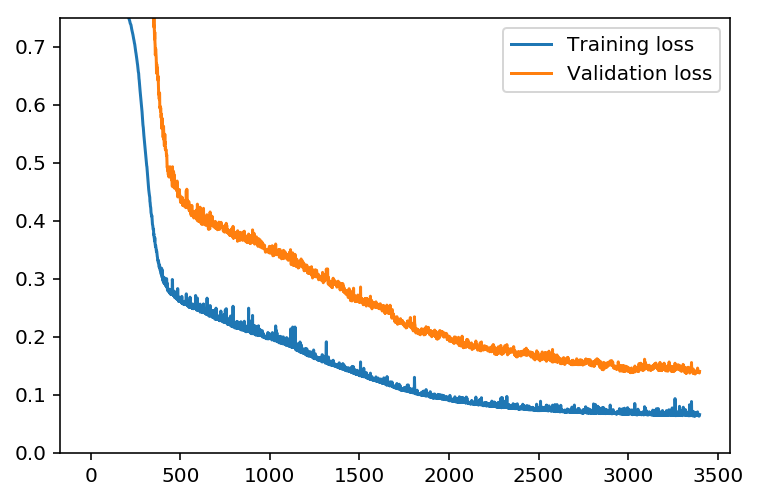

In [17]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim(0,0.75)

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

C:\Users\Szidi\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


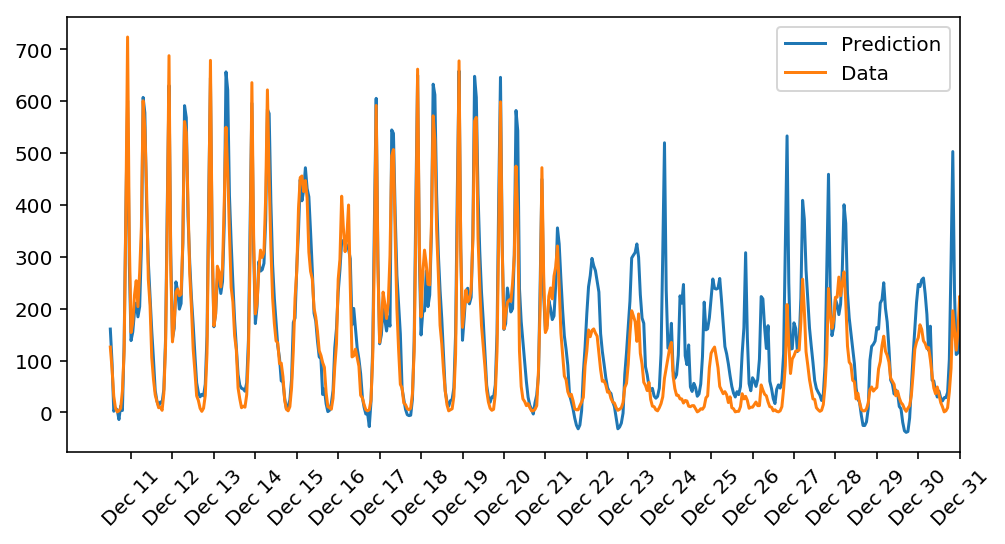

In [18]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below